# Predictive Maintenance

Willkommen zu diesem einführenden Notizbuch zum Thema Predictive Maintenance.

Dieses Dokument ist ein sogenanntes Jupyter Notebook.
Der gesamte Code und alle Technologien bauen auf frei verfügbaren Open-Source-Technologien auf.

Das Notebookdokumentenformat erlaubt es Dokumentation, Code und Ergebnisse in einem einzelnen Dokument übersichtlich zusammenzufassen.
Eine interaktive Demo kann online kostenlos ausprobiert werden.
Dazu unter [diesem Link](https://jupyter.org/try) auf "Try Classic Notebook" klicken.

Ein Notebook besteht aus sogenannten "Zellen", die Code oder Text enthalten können.
Im Hintergrund läuft ein "Kernel", der die Codezellen ausführt - in diesem Fall Python.

Zum Ausführen des Codes auf dem eigenen Rechner wird dementsprechend Python und eine Jupyter(lab)installation benötigt.
Unter Windows oder auch Mac empfiehlt sich eine Installation mit [Anaconda](https://www.anaconda.com/distribution/), unter Linux sollten die notwendigen Pakete über die Paketverwaltung der Distributionen zu enthalten sein.

## Python

Wir nutzen hier zwei Kernbibliotheken:

- `pandas`, eine Bibliothek um Datenanalysen auf tabellarischen und damit strukturierten Daten durchzuführen.
- `scikit-learn`, eine Bibliothek, die  Implementierungen von vielen "klassischen" Machinelearningalgorithmen enthält.


## Datensatz

Für unser kleines Beispiel nutzen wir einen frei verfügbaren Datensatz aus dem [Nasa Prognostics Data Repository](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/).
Der Datensatz heißt "Turbofan Engine Degradation Simulation Data Set" und kann aus dem Repository geladen werden:

```
A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA
```

Wir entpachen den Datensatz in den Ordner `CMAPSSData`

Die Daten simulieren den sich schleichend verschlechternden Zustand von Flugzeugturbinen.
Das Datenpaket enthält Dateien, die unterschiedliche Szenarien beschreiben.
Wir nutzen hier das erste Datenset (FD001), das eine Schadensart modelliert.

Zunächst laden wir die Daten und verschaffen uns einen groben Überblick:

In [20]:
import pandas as pd
pd.set_option('display.max_columns', 500)
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
%matplotlib inline

def lade_daten(path):
    '''Returniert Daten als "Tabellenobjekt" (DataFrame)'''
    spalten = ["id", "cycle", "setting1", "setting2", "setting3",
               "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9",
               "s10", "s11", "s12", "s13", "s14", "s15", "s16", "s17",
               "s18", "s19", "s20", "s21"]
    df = pd.read_csv(path, delim_whitespace=True, names=spalten, dtype=float)
    return df

trainings_pfad = "./CMAPSSData/train_FD001.txt"
test_pfad = "./CMAPSSData/test_FD001.txt"
RUL_pfad = "./CMAPSSData/RUL_FD001.txt"

df_training = lade_daten(trainings_pfad)

In [21]:
# Zeige die ersten paar Zeilen
df_training.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1.0,1.0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190
1,1.0,2.0,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236
2,1.0,3.0,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442
3,1.0,4.0,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739
4,1.0,5.0,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044


Obige Tabelle zeigt einen Ausschnitt aus den Daten.
Jede Zeile entspricht einem Messdatensatz.
`id` steht für die Turbinenid, `cycle` beschreibt den zeitlichen Verlauf, `setting` eins bis drei unterschiedliche Betriebsarten und alle `s`-Spalten sind die eigentlichen Sensormesswerte.


# Fragestellung

Wir stellen eine vereinfachte Frage: anstatt vorherzusagen zu wollen, wann genau eine Turbine defekt sein wird, versuchen wir nur vorherzusagen, ob eine Turbine in den nächsten 30 Zyklen kaputt gehen wird.

Dazu nutzen wir die vorhandenen Daten und fügen eine neue Spalte "WillFail" zum Datensatz hinzu, die nur True/False als Werte enthalten kann.

In [22]:
def vorverarbeite_daten(df):
    '''Erzeugt eine zusaetzliche Spalte, ob Turbine in den naechsten 30 Tagen versagen wird.'''
    # Erzeuge eine temporäre, berechnete Hilfsspalte "RUL" (Remaining Useful Life)
    df_max_cycles = pd.DataFrame(df.groupby(by="id")["cycle"].max().rename("max"))
    df_with_max_cycles = df.merge(df_max_cycles, on="id", how='inner')
    df["RUL"] = df_with_max_cycles["max"] - df_with_max_cycles["cycle"]

    # Erzeuge Klasisfikationsspalte: wird Turbine in den nächsten 30 Zyklen versagen?
    df["WillFail"] = df.apply(lambda row: True if row["RUL"] <= 30 else False,
                              axis='columns')
    df = df.drop(["RUL", "id"], axis='columns')
    return df

df_training = vorverarbeite_daten(df_training)
df_training.head()

,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,WillFail
0,1.0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190,False
1,2.0,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236,False
2,3.0,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442,False
3,4.0,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739,False
4,5.0,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044,False


Die neu hinzugefügte Spalte "WillFail" sehen wir ganz rechts.

Verschiedene Messwerte können auf ganz unterschiedlichen Skalen wirken.
Drücke vielleicht in Vielfachen von $10^5\,\mathrm{Pa}$, Frequenzen vielleicht im einstelligen Hertzbereich.
Um die Werte in der Modellwichtung vergleichbarer zu machen, können wir sie normalisieren, auch wenn das für den Algorithmus, den wir hier anwenden, nicht unbedingt notwendig wäre.
In diesem Beispiel passen wir den Wertebereich aller Messwerte auf den Bereich $[0, 1]$ an:

In [23]:
def normalisiere_daten(df, scaler=None):
    '''Normalisiere Daten.'''
    if scaler is None:
        scaler = MinMaxScaler()
    exclude = ["WillFail"]
    columns = [c for c in df.columns if c not in exclude]
    df.loc[:, columns] = scaler.fit_transform(df.loc[:, columns])
    return df, scaler

df_training, scaler = normalisiere_daten(df_training)
df_training.head()

,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,WillFail
0,0.00000,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,False
1,0.00277,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,False
2,0.00554,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,False
3,0.00831,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,False
4,0.01108,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,False


Wir können direkt auf Spalten verzichten, die nur einen Wert beinhalten - zum Beispiel `setting3` oder `s1`.
Diese Spalten beinhalten keinerlei nützliche Information um auf die Vorhersagespalte zu schließen.

In [24]:
# Behalte nur Spalten, die mehr als einen Wert beinhalten
spalten = [c for c in df_training.columns if len(df_training.loc[:, c].unique()) > 1]
df_training = df_training.loc[:, spalten]

Das Modell wird immer nur mit einem Teil der Daten angepasst, den sogenannten Trainingsdaten.
Die restlichen Daten werden genutzt um die Qualität des angepassten Modells zu bewerten.

In unserer einfachen Version hier nutzen wir nur einen Trainings- und einen Testdatensatz.
Für den Testdatensatz nutzen wir nur die aktuellsten Daten, also den letzten Zustand der Turbine.

In [25]:
# Nutze lediglich die letzte Zeile für jede Turbine aus den Testdaten
df_test = lade_daten(test_pfad)
df_test = df_test.loc[df_test.groupby('id').cycle.idxmax()]

# Überprüfe ob Turbine in den nächsten 30 Zyklen kaputt gehen wird
df_max_cycles = pd.read_csv(RUL_pfad, delim_whitespace=True, names=["WillFail"])
df_max_cycles.index += 1
df_max_cycles['id'] = df_max_cycles.index
df_max_cycles['WillFail'] = df_max_cycles.apply(lambda row: 1 if row["WillFail"] <= 30 else 0, axis=1)

# Füge RUL und Testdatensatzinformation zusammen
df_test = df_test.merge(df_max_cycles, on="id", how='inner')
df_test = df_test.drop(["id"], axis=1)
df_test, _ = normalisiere_daten(df_test, scaler)
df_test = df_test.loc[:, spalten]

Ziel ist es nun, für eine gegebene Turbine "WillFail" korrekt vorherzusagen.
Die Problemstellung hat zwei Charakteristiken:

- Es ist eine binäre Klassifikation: nur zwei Zustände sind möglich
- Es handelt sich um Supervisesd Learning: unser Algorithmus nutzt die "korrekte" Lösung zum Lernen und seine Qualität kann anhand der korrekten Lösung gemessen werden.

Für dieses Beispiel nutzen wir einen der einfachsen Machinelearningalgorithmen: die sogenannten [logistische Regression](https://de.wikipedia.org/wiki/Logistische_Regression).
In der Kurzerklärung: wir betrachten die logistische Funktion:

https://de.wikipedia.org/wiki/Logistische_Regression#/media/Datei:Mplwp_logistic_function.svg

In dieser Funktion nehmen wir also einen beliebigen Eingangswert auf der horizontalen Achse (x-Achse) und erhalten immer einen Wert zwischen 0 und 1.
Ist der erhaltene Funktionswert größer als ein definierter Schwellwert, zum Beispiel $0,5$, so klassifizieren wir den Eingabewert als 0 (in unserem Beispiel: die Turbine wird nicht kaputt gehen), oder 1 (dir Turbine wird kaputt gehen).

Als Eingangsdaten auf der x-Achse nutzen wir eine Summation unserer vorhandener Spalten: $\sum_{i=1}^{i=n} w_i x_i$, wobei $i$ für die jeweilige Spalte steht, $x_i$ für den entsprechenden Wert und $w_i$ für eine Wichtung der Spalte.

Vereinfacht wird unser Algorithmus nun so arbeiten:

- Er sucht zufällige Werte für die Wichtung unserer Spalten, $w_i$.
- Er schleust die Trainingsdaten durch die nun definierte Formel, berechnet das Klassifikationsergebnis und vergleicht dieses Ergebnis mit der korrekten, bekannten Antwort.
- Mit Hilfe eines Optimierungsalgorithmus wandelt er die Wichtungen $w_i$ ab und wiederholt den Vorgang.

Der Code hierfür ist recht einfach zu nutzen:

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Initialisiere und passe Modell an
clf = LogisticRegression(solver='lbfgs')
clf.fit(df_training.loc[:, df_training.columns != "WillFail"],
        df_training["WillFail"])

# Nutze Testdaten um Ergebnis zu überprüfen
y_pred = clf.predict(df_test.loc[:, df_test.columns != "WillFail"])
y_true = df_test["WillFail"]

# Berechne Qualitätmaßzahlen
scores = dict()
scores["Accuracy"] = accuracy_score(y_true, y_pred)
scores["Precision"] = precision_score(y_true, y_pred)
scores["Recall"] = recall_score(y_true, y_pred)
scores["F-Score"] = f1_score(y_true, y_pred)

Schlussendlich muss bewertet werden, wie gut der Algorithmus funktioniert.
Hierzu haben wir zuvor die Testdaten in das angepasste Modell gegeben.
Jetzt können wir unsere Vorhersage mit den korrekten Ergebnissen vergleichen.
Hierzu visualisieren wir die Ergebnisse mit einer sogenannten Konfusionsmatrix:

[Text(0.5,15,'Vorhersage')]

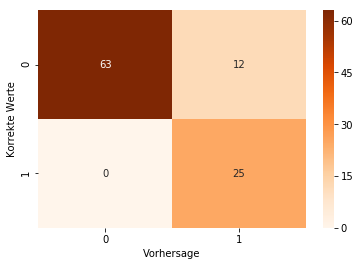

In [27]:
import seaborn as sbn
conf_matrix = confusion_matrix(y_true, y_pred)
heatmap = sbn.heatmap(conf_matrix, annot=True, cmap='Oranges')#, fmt='d')
heatmap.set(ylabel='Korrekte Werte')
heatmap.set(xlabel='Vorhersage')

Die Konfusionsmatrix liest sich wie folgt:

- In der ersten Zeile haben wir 63 mal korrekt vorhergesagt, dass die Turbine in den nächsten 30 Zyklen nicht kaputt gehen wird, aber 12 Mal fälschlicherweise einen Defekt vorhergeagt, obwohl sie nicht kaputt gehen wird.
- In der zweiten Zeile haben wir 0 Mal vorhergesagt, dass die Turbine nicht kaputt gehen wird, obwohl ein Defekt eintreten wird und 25 Mal korrekt vorhergesagt, dass die Turbine defekt sein wird.

Wie gut ist unser Modell also?
Die Bewertung der Modellgüte hängt vom Anwendungsfall ab.
In unserem Anwendungsfall wäre es wohl intuitiv schlimmer, keinen Defekt vorherzsuagen, obwohl dann ein Defekt auftritt, als andersherum.

Zum Abschluss: dieses Notebook zeigt ein eingängiges Minimalbeispiel.
Wir hoffen, dass wir hier den Appetit für das Thema wecken und einen groben Einblick in die Welt des Machinelearning geben konnten.
Die hier gezeigte Lösung ist natürlich  in keiner Weise state-of-the-art und nutzt an einigen Stellen grobe Vereinfachungen.